In [1]:
print("Hello World")

Hello World


In [2]:
from datasets import Dataset,load_dataset
 
import torch,transformers
 

from transformers import (GemmaTokenizerFast, TrainingArguments, Trainer,
                          Gemma2ForSequenceClassification, DataCollatorWithPadding,
AutoModelForCausalLM, BitsAndBytesConfig ,AutoModelForSequenceClassification, AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,)
 
from peft import LoraConfig,TaskType,PeftModel
 


TRAINING = False
if TRAINING:
    from trl import RewardTrainer,RewardConfig
    import trl
trained_peft_path = "/kaggle/input/wsdm-checkpoint-2-5k"

**Reward Model**

A Reward model is the one of the important component in RLHF which is used to fine train the LLM. This kind of fine tuning model that learn to predict a reward score based on the human feedback

In [3]:
if TRAINING:
    !pip install -U bitsandbytes trl

**Dataset**

Dataset format should be contains 


**prompt**: The question or statement to which responses are provided.

**chosen**: The response that is considered better or more appropriate.

**rejected**: The response that is less appropriate or of lower quality.

{"*prompt*": "What are the health benefits of regular exercise?", 
"*chosen*": "Regular exercise improves cardiovascular health, strengthens muscles, enhances flexibility, boosts mental health, and aids in weight management.", 
"*rejected*": "Regular exercise is good."}

In [4]:
#file uploading
train_data = load_dataset(path = "/kaggle/input/wsdm-cup-multilingual-chatbot-arena/",data_files=['train.parquet'],split="train")
test_data = load_dataset(path = "/kaggle/input/wsdm-cup-multilingual-chatbot-arena/",data_files=['test.parquet'])

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Training with reward model (note rewritten with chatgpt)

In training a reward model, the goal is to teach the model to assign **higher scores to preferred responses** and **lower scores to less preferred ones**. This is achieved by minimizing a specific loss function that measures how well the model distinguishes between chosen and rejected responses.

$$
\mathcal{L}(\theta) = -\frac{1}{\binom{K}{2}} \sum_{(x, y_w, y_l) \in D} \log \left( \sigma \left( r_\theta(x, y_w) - r_\theta(x, y_l) \right) \right)
$$

**Prompt (x)**: "What are the health benefits of regular exercise?"
**Preferred Response (y_w)**: "Regular exercise improves cardiovascular health, strengthens muscles, enhances flexibility, boosts mental health, and aids in weight management."
**Less Preferred Response (y_l)**: "Regular exercise is good."
 
 
 

In [5]:
 def formatting_func(examples):
    kwargs = {"padding": "max_length", "truncation": True, "max_length": 512, "return_tensors": "pt"}

    # Prepend the prompt and a line break to the original_response and response-1 fields.
    prompt_plus_chosen_response = examples["instruction"] + "\n" + examples["chosen_response"]
    prompt_plus_rejected_response = examples["instruction"] + "\n" + examples["rejected_response"]

    # Then tokenize these modified fields.
    tokens_chosen = tokenizer.encode_plus(prompt_plus_chosen_response, **kwargs)
    tokens_rejected = tokenizer.encode_plus(prompt_plus_rejected_response, **kwargs)

    return {
        "input_ids_chosen": tokens_chosen["input_ids"][0], "attention_mask_chosen": tokens_chosen["attention_mask"][0],
        "input_ids_rejected": tokens_rejected["input_ids"][0], "attention_mask_rejected": tokens_rejected["attention_mask"][0]
    }



 
1. Compute Scores: The reward model assigns scores to both responses:\
**r_θ(x,y_w)** = score of preferred response
\
**r_θ(x,y_l)** = score of less preferred response\
2. Calculate Score Difference: Compute the difference:\
   **Δr** = r_θ(x,y_w) - r_θ(x,y_l)\
3. Apply Sigmoid Function: Calculate the sigmoid of the score difference:\
  **σ(Δr)**
4. Compute Logarithm: Take the natural logarithm:\
    **log(σ(Δr))**
5. Calculate Loss: Compute the loss for this example:\
     **L_example** = −log(σ(Δr)) 

<font size="5">If the model assigns a higher score to the preferred response than to the less preferred one, Δ𝑟 will be positive, making σ(Δr) close to 1, and log(σ(Δr)) close to 0. This results in a low loss, indicating good performance. Conversely, if the model assigns a higher score to the less preferred response, Δr will be negative, σ(Δr) will be close to 0, log(σ(Δr)) will be a large negative number, and the loss will be high, indicating poor performance.</font>

<font size="5">By minimizing this loss function during training, the reward model learns to assign higher scores to responses that align with human preferences, effectively capturing the desired behavior.</font>

In [6]:
if TRAINING:
    all_rows = []
    for i in train_data:
        chosen_response = i[i['winner']]
        if i['winner'].endswith("a"):
            chosen_response = i['response_a']
        else:
            rejected_response = i['response_a']
    
        if i['winner'].endswith("b"):
            chosen_response = i['response_b']
        else:
            rejected_response = i['response_b']
    
        
        all_rows.append({
            "instruction": i["prompt"],
            "chosen_response":  chosen_response,
            "rejected_response":  rejected_response
        })
    prepared_dataset = Dataset.from_list(all_rows)


Reference : [https://arxiv.org/pdf/2303.00001](http://)


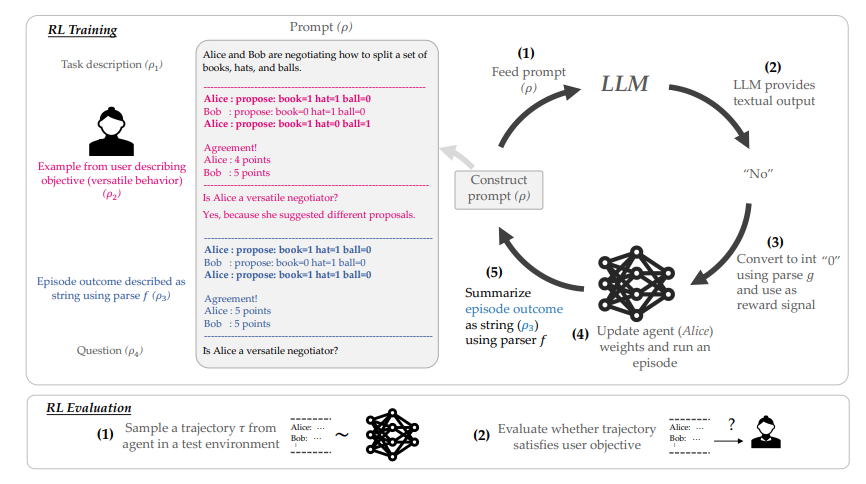





In [7]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="/kaggle/input/tokenizer-qwen2-5")
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/input/qwen2.5/transformers/0.5b-instruct/1", num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
if TRAINING:
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=8,
        lora_alpha=32,
        lora_dropout=0.1,
    )
    formatted_dataset = prepared_dataset.map(formatting_func)
    formatted_dataset = formatted_dataset.train_test_split()
    training_args = RewardConfig(output_dir="gemma-2B-Reward",
                             logging_dir=".",
                            report_to=["none"],
                            save_total_limit=1,
                            overwrite_output_dir=True,
                            per_device_train_batch_size=1,
                             learning_rate=5e-5,weight_decay=0.01,
                            num_train_epochs=1)
    trainer = RewardTrainer(
    model=model,
    args=training_args,
     processing_class=tokenizer,
     peft_config=peft_config,
    train_dataset=formatted_dataset["train"],
    eval_dataset=formatted_dataset["test"],
 
)

    trainer.train()

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/qwen2.5/transformers/0.5b-instruct/1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
 ###########
if not TRAINING:
    reward_model = PeftModel.from_pretrained(model, trained_peft_path)
    model = reward_model.merge_and_unload() 

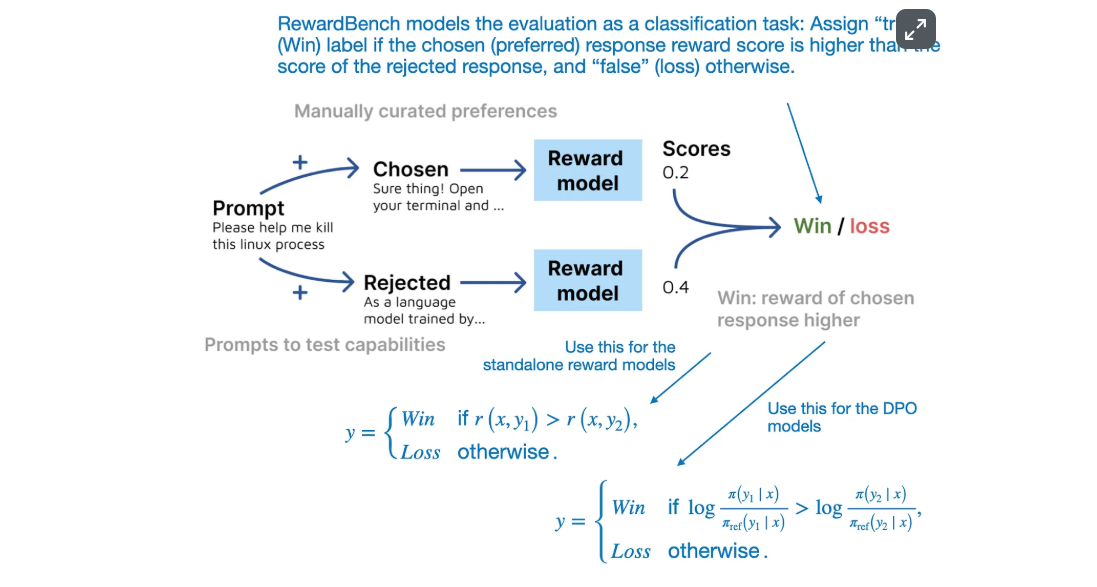

In [9]:
model.to("cuda")

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): 

In [10]:
def get_score(model, tokenizer, prompt, response):
    kwargs = {"padding": "max_length", "truncation": True, "max_length": 512, "return_tensors": "pt"}
    # Tokenize the input sequences
    inputs = tokenizer.encode_plus(prompt+"\n"+response, **kwargs).to("cuda")

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_class = logits.argmax(dim=-1).item()

    return logits

In [11]:
 def test(x):
  a =  get_score(model, tokenizer,  x['prompt'],  x['response_a'])
  b =  get_score(model, tokenizer,  x['prompt'], x['response_b'])
 
  if a.sum() < b.sum():
      result = "model_a"
  else:
      result= "model_b"
  x['winner'] = result
  return x

In [12]:
submit = test_data['train'].map(test,remove_columns=[ 'prompt', 'response_a', 'response_b', 'scored']).to_pandas()
 

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [13]:
 submit  

,id,winner
0,327228,model_b
1,1139415,model_a
2,1235630,model_a


In [14]:
submit.to_csv('submission.csv', index=False)